In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **SET FUNCTIONS**

## Load and prepare data

In [2]:
import numpy as np
def prepareData(dataInputPath, validateFraction):

    trainEvents = np.load(dataInputPath)
    validateSize = int(len(trainEvents) * validateFraction)
    
    validateEvents = np.array(trainEvents[-validateSize:])
    trainEvents = np.array(trainEvents[:-validateSize])

    trainEvents = trainEvents.astype('float16')
    validateEvents = validateEvents.astype('float16')

    return [trainEvents, validateEvents]

## Create and prepare network

In [8]:
import tensorflow as tf
import keras
from keras import layers
import pickle

def trainNeuralNetwork(modelOutputPath, trainEvents, validateEvents, singleInputShape, parameters):

    encoderInput = keras.Input(shape=(singleInputShape['x'], singleInputShape['y'], singleInputShape['channels']))

    x = layers.Conv2D(16, (4,3), activation='relu', padding='same')(encoderInput)
    x = layers.MaxPooling2D(pool_size=(4,4))(x)

    x = layers.Conv2D(32, (4,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l=0.0001))(x)
    x = layers.MaxPooling2D(pool_size=(4,4))(x)

    x = layers.Conv2D(64, (4,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l=0.0001))(x)

    x = layers.Conv2D(64, (4,4), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l=0.0001))(x)
    x = layers.UpSampling2D((4,4))(x)

    x = layers.Conv2D(32, (4,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l=0.0001))(x)
    x = layers.UpSampling2D((4,4))(x)

    decoderOutput = layers.Conv2D(4, (4,3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(encoderInput, decoderOutput, name="autoencoder")
    autoencoder.summary()

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = autoencoder.fit(trainEvents, trainEvents,
                epochs = parameters["epochs"],
                batch_size= parameters["batchSize"],
                shuffle = True,
                validation_data = (validateEvents, validateEvents))

    if modelOutputPath != '0':
        import time
        path = modelOutputPath + time.strftime("autoencoder_%d-%m-%Y_%H-%M-%S")
        autoencoder.save(path)
        f = open(path + '/history.pckl', 'wb')
        pickle.dump(history.history, f)
        f.close()

    return [history, autoencoder]

## Load trained network (instead)

In [5]:
import numpy as np
import keras

def loadTrainedModel(loadedModelPath):
    f = open('history.pckl', 'rb')
    history = pickle.load(f)
    f.close()
    return [keras.models.load_model(loadedModelPath), history]

## Plot results

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plotResults(autoencoder, validateEvents, singleInputShape, history, shownEventNumber):
    encodedEvents = autoencoder.predict(validateEvents)
    plotLossAccuracy(history)
    calculateThresholds(encodedEvents, validateEvents, singleInputShape)
    showReconstructedEvents(shownEventNumber, validateEvents, encodedEvents)

def plotLossAccuracy(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title("cost function")
    plt.xlabel("epoch")
    plt.ylabel("cost")
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def calculateThresholds(encodedEvents, validateEvents, singleInputShape):

    flatLength = singleInputShape["x"] * singleInputShape["y"] * singleInputShape["channels"]
    encodedEventsFlat = np.reshape(encodedEvents, [len(encodedEvents), flatLength])

    # TODO repair reconstruction error, maybe change reshaping

    validateEventsFlat = np.reshape(validateEvents, [len(encodedEvents), flatLength])
    reconstructionErrors = tf.keras.losses.mse(encodedEventsFlat, validateEventsFlat)
    encodedEventsFlat = None
    validateEventsFlat = None

    anomalyThreshold = np.mean(reconstructionErrors.numpy()) + np.std(reconstructionErrors.numpy())
    print("Reconstruction error threshold: ", anomalyThreshold)

    # Train MAE loss.
    plt.axvline(anomalyThreshold, color='k', linestyle='dashed', linewidth=1)
    plt.hist(reconstructionErrors, bins=100)
    plt.xlabel("MSE loss")
    plt.ylabel("Number of samples")
    plt.show()

    # Train MAE loss in logarithmic scale
    plt.axvline(anomalyThreshold, color='k', linestyle='dashed', linewidth=1)
    plt.hist(reconstructionErrors, bins=500)
    plt.xlabel("MSE loss")
    plt.ylabel("Number of samples (log)")
    plt.yscale("log")  
    plt.show()



def showReconstructedEvents(eventNumber, validateEvents, encodedEvents):

  n = 4 
  plt.figure(figsize=(20, 4), dpi=200)

  for i in range(0, n):

    # Display original
    ax = plt.subplot(2, n, i + 1)
    img = np.zeros((80,336))
    for l,px in enumerate(validateEvents[i + eventNumber * 4]):
        for k,py in enumerate(px):
            img[k][l] = py[0]
    plt.imshow(img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    dec_img=np.zeros((80,336))
    for l,px in enumerate(encodedEvents[i + eventNumber*4]):
        for k,py in enumerate(px):
            dec_img[k][l]=py[0]


    plt.imshow(dec_img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



  if error_values[eventNumber] < threshold:
      plt.text(-580, -40, 'Reconstruction error: ' + str(error_values[eventNumber]), fontsize = 12)
  else:
      plt.text(-580, -40, 'Reconstruction error: ' + str(error_values[eventNumber]), fontsize = 12, color='r')
  plt.show()

# RUN CODE

## Load and prepare data

In [5]:
inputDataPath = "drive/MyDrive/AFP/input-data/331020_centr_trigger_all_2866.npy"
validateFraction = 0.1

trainEvents, validateEvents = prepareData(inputDataPath, validateFraction)

## Run and train network

In [9]:
outputModelPath = "drive/MyDrive/AFP/trained-models"     # '0': don't save; save with default name
parameters = {"epochs" : 20, 
              "batchSize" : 50}
singleInputShape = {"x" : 336, "y" : 80, "channels" : 4}

history, autoencoder = trainNeuralNetwork(outputModelPath, trainEvents, validateEvents, singleInputShape, parameters)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 336, 80, 4)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 336, 80, 16)       784       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 84, 20, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 84, 20, 32)        6176      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 21, 5, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 5, 64)         24640     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 5, 64)         

## Load trained model instead

In [ ]:
loadedModelPath = "trained-models/autoencoder_04-08-2021_11-14-36"

autoencoder, history = loadTrainedModel(loadedModelPath)

FileNotFoundError: [Errno 2] No such file or directory: 'history.pckl'

## Calculate results

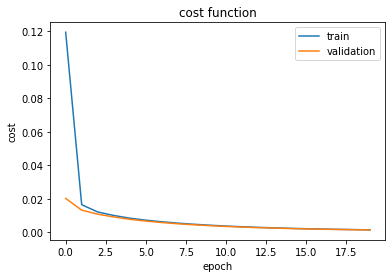

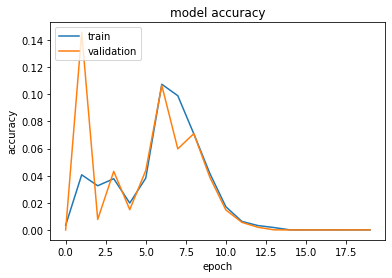

Reconstruction error threshold:  8.744e-05


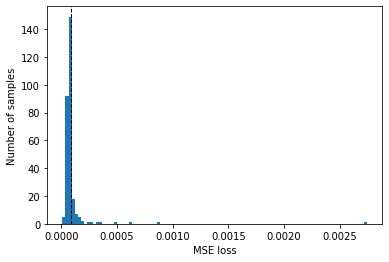

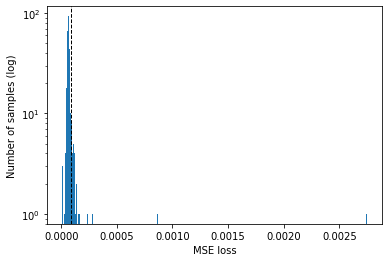

NameError: ignored

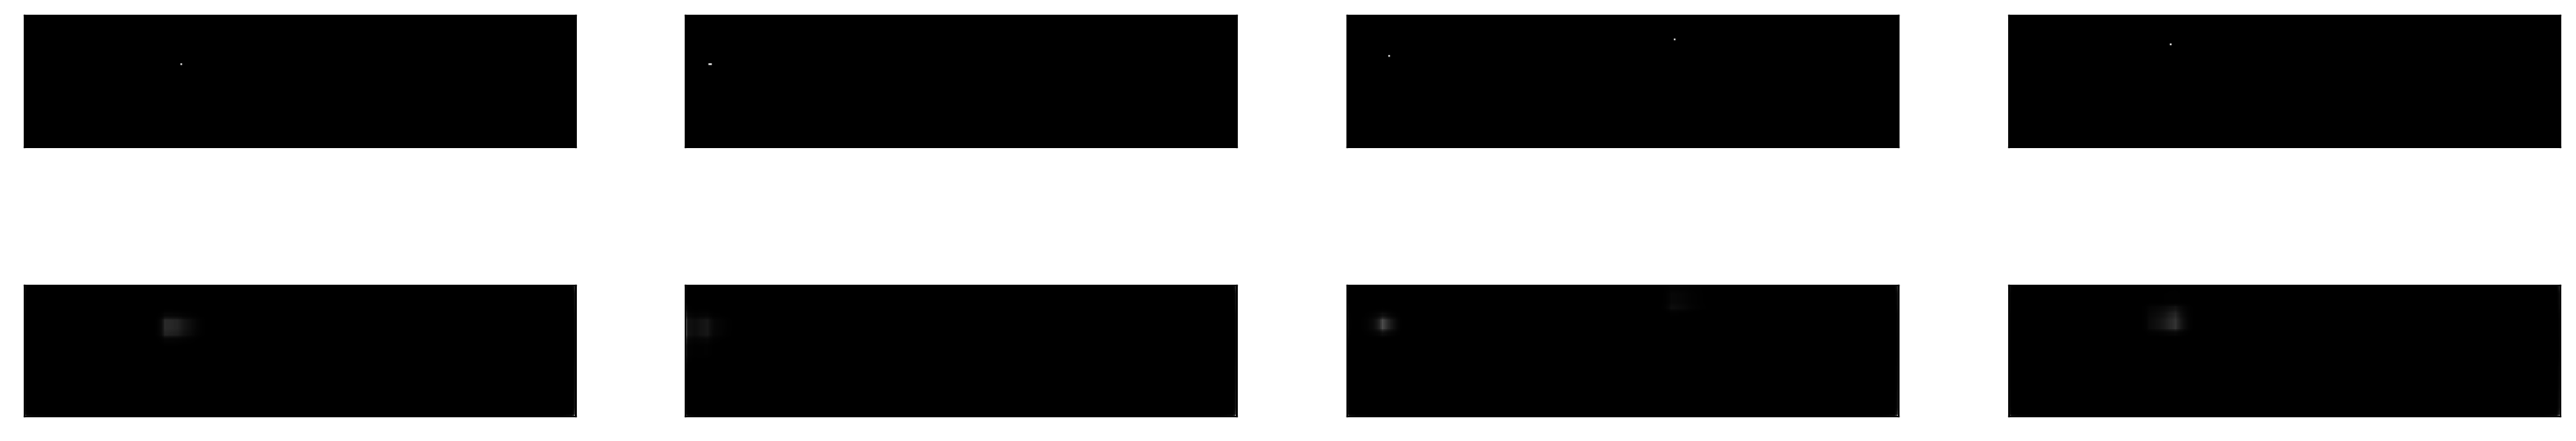

In [19]:
singleInputShape = {"x": 336, "y": 80, "channels": 4}
shownEventNumber = 0

plotResults(autoencoder, validateEvents, singleInputShape, history, shownEventNumber)